### Regression model

In [3]:
import pandas as pd
import geopandas as gpd
import pickle
from pysal.lib import weights # import weight lib
from sklearn.model_selection import train_test_split
from sklearn import cluster
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [34]:
import statsmodels.graphics.api as smg
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tools.eval_measures import rmse
from math import *
from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats

In [5]:
with open('Total.pickle', 'rb') as handle:
    all_cities = pickle.load(handle)

In [6]:
#all_cities = pd.concat([RegDf['rotterdam'], RegDf['munich'], RegDf['zurich'], RegDf['frankfurt'], RegDf['hamburg']])

In [7]:
all_cities = all_cities[all_cities['flow'].notna()]

In [8]:
all_cities = all_cities.fillna(0)

In [30]:
all_cities.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2329 entries, 0 to 2329
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   detid            2329 non-null   object  
 1   flow             2329 non-null   float64 
 2   City             2329 non-null   object  
 3   geometry         2329 non-null   geometry
 4   NeighboursTotal  2329 non-null   float64 
 5   station          2329 non-null   int64   
 6   cycleway         2329 non-null   int64   
 7   footway          2329 non-null   int64   
 8   pedestrian       2329 non-null   int64   
 9   footwayplatform  2329 non-null   float64 
 10  Lag_Flow         2329 non-null   float64 
 11  station_log      2329 non-null   float64 
 12  cycleway_log     2329 non-null   float64 
 13  footway_log      2329 non-null   float64 
 14  pedestrian_log   2329 non-null   float64 
 15  flow_log         2329 non-null   float64 
 16  footway_2        2329 non-null   f

In [49]:
def regression(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')

    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    
    x_train = pd.get_dummies(x_train, columns=['City'])
    x_test = pd.get_dummies(x_test, columns=['City'])
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test, traindf]



### First iteration model

In [64]:
regression_model1, y_train1, x_train1, y_test1, x_test1, predy_test1, train_df1\
= regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian', 'City', 'footwayplatform'], all_cities )

Shape of the training set is (1863, 17) and of the testing set is (466, 17).


In [12]:
print(regression_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     17.69
Date:                Mon, 09 Nov 2020   Prob (F-statistic):           2.08e-28
Time:                        11:59:24   Log-Likelihood:                -11888.
No. Observations:                1863   AIC:                         2.380e+04
Df Residuals:                    1853   BIC:                         2.385e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             177.1601      6.051     

In [13]:
def linearity_check(x_train, y_train, residuals, predy_train):
    # create plot
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    # create regresion between y and predicted y
    sns.regplot(predy_train, y_train, ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # create regression plot with residuals and predicted y
    sns.regplot(predy_train, residuals, ax=ax[1])
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')

    # create kde plot of residuals
    sns.distplot(residuals, ax=ax[2])
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Density')

    fig.suptitle('Linearity test', fontsize=25)

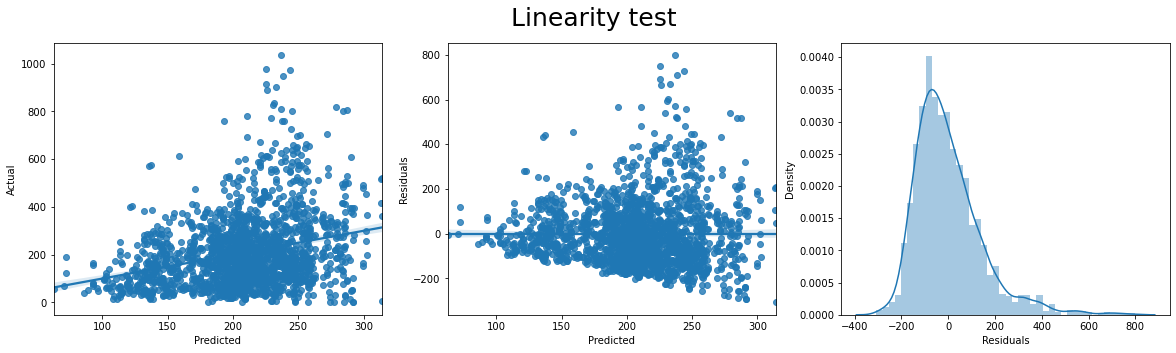

In [14]:
# residual analysis to determine whether assumption of linearity was correct
residuals1 = regression_model1.resid
predy_train1 = regression_model1.fittedvalues
#y_train1 = y_train1.reshape(y_train1.shape[0], )

linearity_check(x_train1, y_train1, residuals1, predy_train1)

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


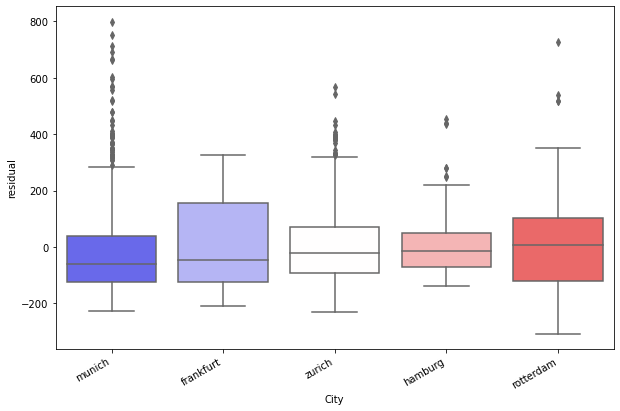

In [15]:
conditions = [
    x_train1['City_hamburg'] == 1, 
    x_train1['City_munich'] == 1, 
    x_train1['City_rotterdam'] == 1,
    x_train1['City_zurich']  == 1,
    x_train1['City_frankfurt'] == 1
]

outputs = [
    'hamburg', 'munich', 'rotterdam', 'zurich', 'frankfurt'
]



x_train_cities = x_train1[['station', 'cycleway', 'footway', 'pedestrian']]
x_train_cities['City'] = np.select(conditions, outputs, 'Other')
x_train_cities['residual'] = residuals1.values

medians = x_train_cities.groupby("City").residual.median().to_frame('city_residual')

f = plt.figure(figsize=(10,7))
ax = plt.gca()
sns.boxplot('City', 'residual', ax = ax,
                data=x_train_cities.merge(medians, how='left',
                              left_on='City',
                              right_index=True)
                   .sort_values('city_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [16]:
def get_teststats(y_test, predy_test):
    r2_score_test = r2_score(y_test, predy_test)
    MAE = mean_absolute_error(y_test, predy_test)
    mse = mean_squared_error(y_test, predy_test)
    rmse = sqrt(mse)
    return r2_score_test, MAE, rmse

In [17]:
R2score_model1, MAE_model1, rmse_model1 = get_teststats(y_test1, predy_test1)
print(f'R2-score 1: {R2score_model1}')
print(f'MAE 1:{MAE_model1}')
print(f'rmse 1: {rmse_model1}')

R2-score 1: 0.040635521638615946
MAE 1:107.91540833136604
rmse 1: 136.53718972439438


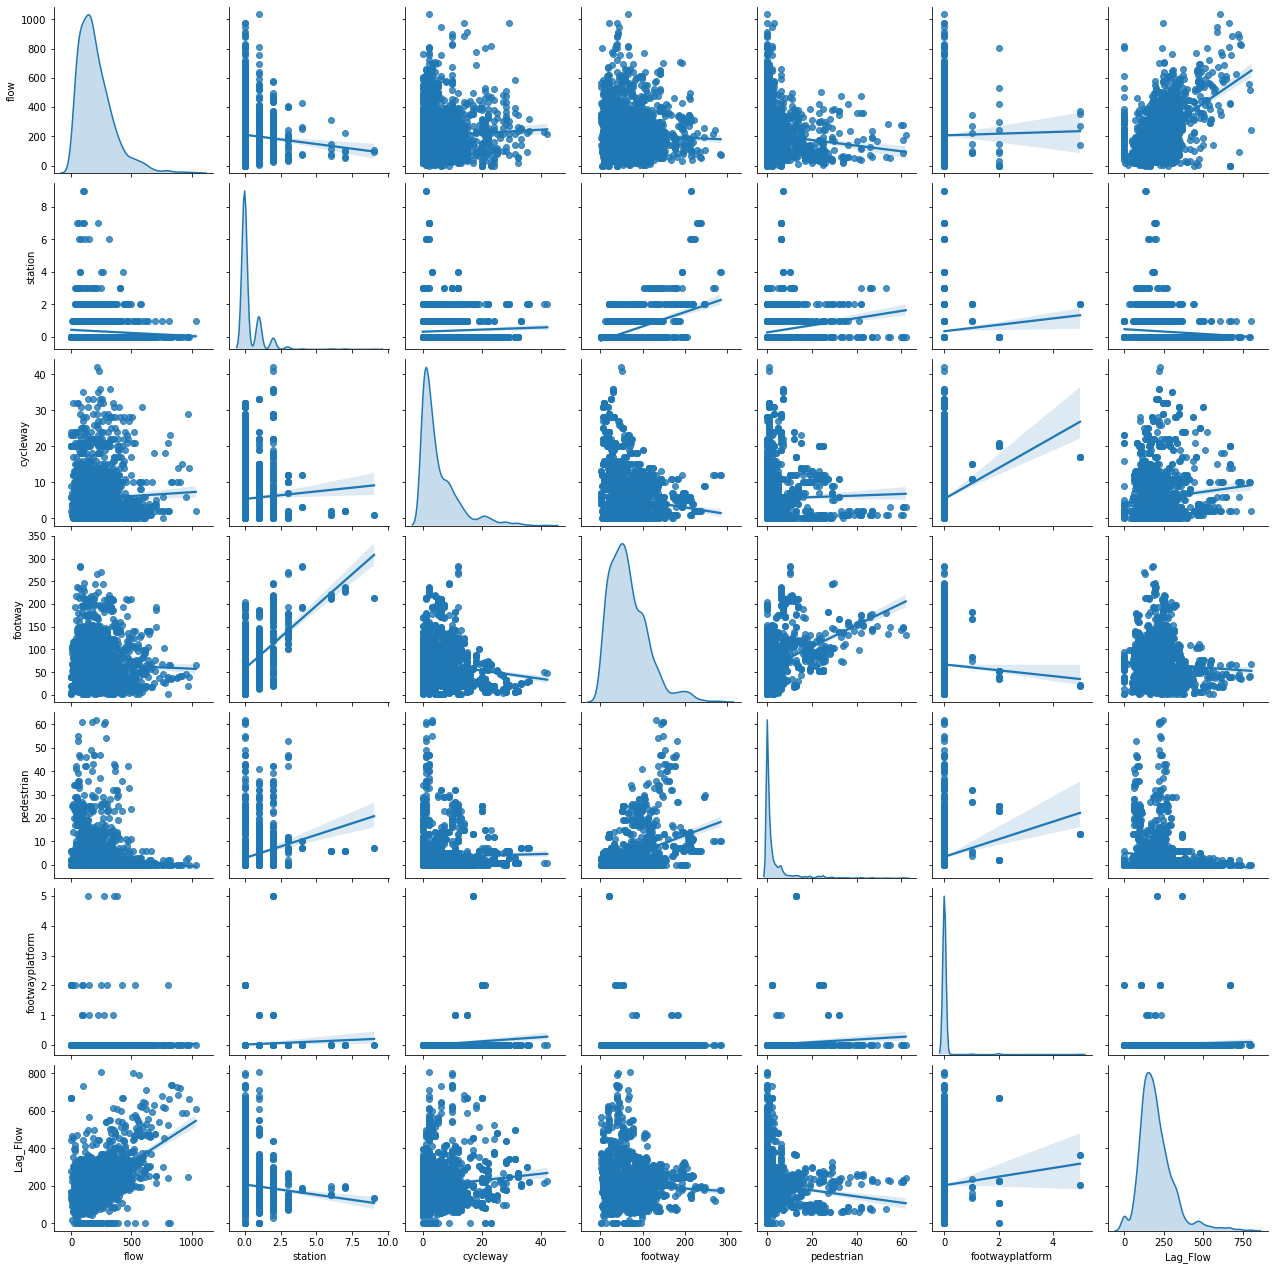

In [18]:
_ = sns.pairplot(all_cities[['flow', 'station', 'cycleway', 'footway', 'pedestrian', 'footwayplatform', 'Lag_Flow']], kind='reg', diag_kind='kde')

### Second iteration model

choices:
-create log of skewed variables
-remove footwayplatforms, since it's not very significant

In [19]:
all_cities['station_log'] = np.log(all_cities['station'].replace(0, np.nan))
all_cities['cycleway_log'] = np.log(all_cities['cycleway'].replace(0, np.nan))
all_cities['footway_log'] = np.log(all_cities['footway'].replace(0, np.nan))
all_cities['pedestrian_log'] = np.log(all_cities['pedestrian'].replace(0, np.nan))
all_cities['flow_log'] = np.log(all_cities['flow'].replace(0, np.nan))

# create second degree polynomial
polynomial_features= PolynomialFeatures(degree=2)
poly_constructionyear = polynomial_features.fit_transform(all_cities[['footway']])
all_cities['footway_2'] = pd.DataFrame(poly_constructionyear)[2].values

all_cities = all_cities.fillna(0)

In [20]:
#all_cities.head()

In [50]:
regression_model2, y_train2, x_train2, y_test2, x_test2, predy_test2, train_df2\
= regression(['flow'], ['station', 'cycleway_log', 'footway', 'footway_2', 'pedestrian_log', 'City'], all_cities)

Shape of the training set is (1863, 17) and of the testing set is (466, 17).


In [22]:
print(regression_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     18.47
Date:                Mon, 09 Nov 2020   Prob (F-statistic):           9.44e-30
Time:                        12:00:10   Log-Likelihood:                -11885.
No. Observations:                1863   AIC:                         2.379e+04
Df Residuals:                    1853   BIC:                         2.385e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            192.6792      8.326     23.

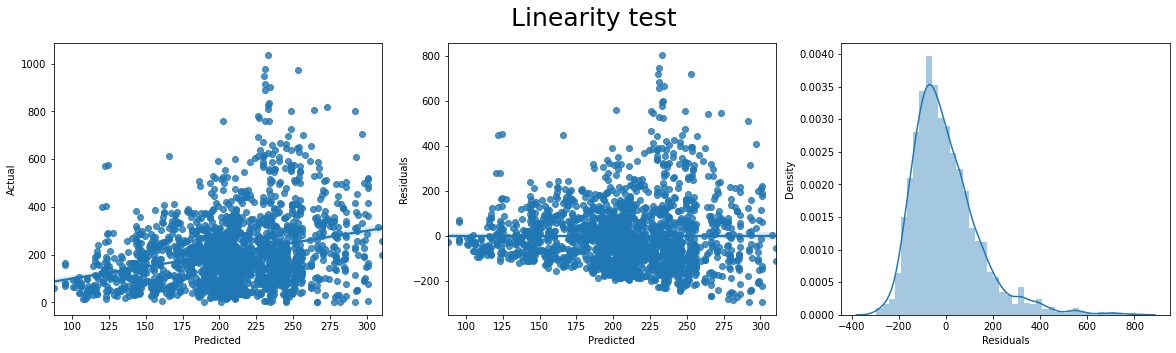

In [105]:
# residual analysis to determine whether assumption of linearity was correct
residuals2 = regression_model2.resid
predy_train2 = regression_model2.fittedvalues
#y_train2 = y_train2.reshape(y_train2.shape[0], )

linearity_check(x_train2, y_train2, residuals2, predy_train2)

In [118]:
R2score_model2, MAE_model2, rmse_model2 = get_teststats(y_test2, predy_test2)
print(f'R2-score 2: {R2score_model2}')
print(f'MAE 2:{MAE_model2}')
print(f'rmse 2: {rmse_model2}')


R2-score 2: 0.03921253224476562
MAE 2:108.19312559984249
rmse 2: 136.63841245281318


### Third iteration model

In [115]:
regression_model3, y_train3, x_train3, y_test3, x_test3, predy_test3, train_df3\
= regression(['flow'], ['station', 'cycleway_log', 'footway', 'footway_2', 'pedestrian_log', 'City', 'Lag_Flow'], all_cities)

Shape of the training set is (1863, 17) and of the testing set is (466, 17).


In [116]:
print(regression_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     90.98
Date:                Mon, 09 Nov 2020   Prob (F-statistic):          7.19e-153
Time:                        13:05:54   Log-Likelihood:                -11593.
No. Observations:                1863   AIC:                         2.321e+04
Df Residuals:                    1852   BIC:                         2.327e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             57.3571      8.804      6.

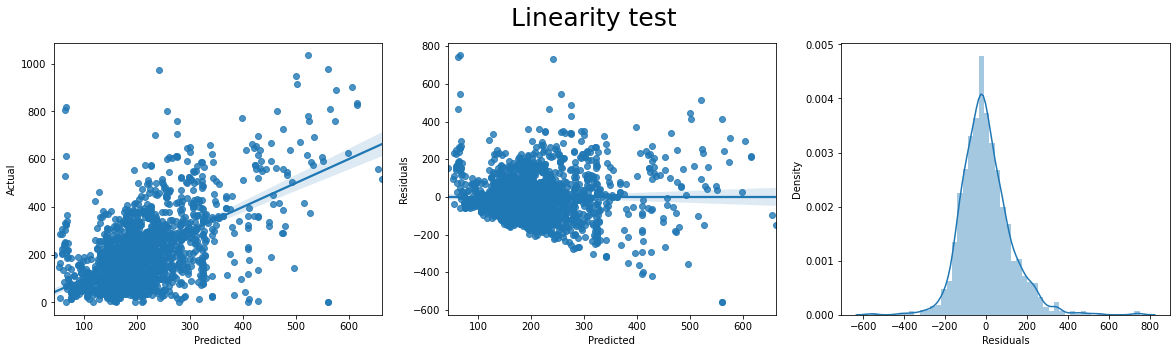

In [99]:
# residual analysis to determine whether assumption of linearity was correct
residuals3 = regression_model3.resid
predy_train3 = regression_model3.fittedvalues
#y_train3 = y_train3.reshape(y_train3.shape[0], )

linearity_check(x_train3, y_train3, residuals3, predy_train3)

In [117]:
R3score_model3, MAE_model3, rmse_model3 = get_teststats(y_test3, predy_test3)
print(f'R3-score 3: {R3score_model3}')
print(f'MAE 3:{MAE_model3}')
print(f'rmse 3: {rmse_model3}')


R3-score 3: 0.2122582827161439
MAE 3:92.14605739309215
rmse 3: 123.72317756856211


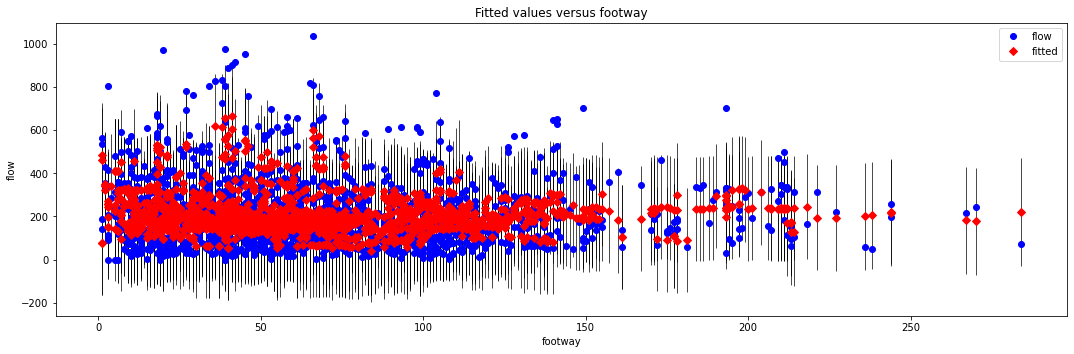

In [167]:
# was chosen on the x-axis since that showed the values the most clearly
fig, ax = plt.subplots(figsize = (15, 5))
fig = sm.graphics.plot_fit(regression_model2, 3, ax=ax)
fig.tight_layout(pad=1.0)

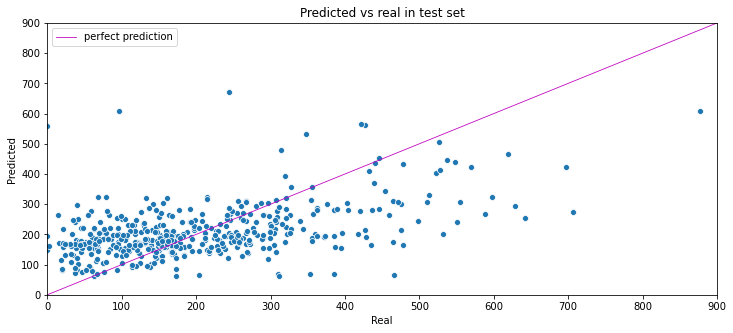

In [202]:
#y_test3 = y_test3.reshape(y_test3.shape[0], )

# create regresion between y and predicted y
fig, ax = plt.subplots(figsize = (12, 5))
test_scatter = sns.scatterplot(y_test3['flow'], predy_test3, ax=ax)

# create perfect prediction line
x1 = [0, 900]
y1 = [0, 900]
sns.lineplot(x1, y1, color = "m", linewidth = 0.8, label = 'perfect prediction')

ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
ax.set_title('Predicted vs real in test set')
ax.set_xlim([0,900])
ax.set_ylim([0,900])

plt.show()

### spatial lag and stuff

In [97]:
w_cities = weights.KNN.from_dataframe(train_df3, k=20, ids='detid')
#w_cities = weights.distance.DistanceBand.from_dataframe(train_df2, threshold = 250, ids='detid')


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


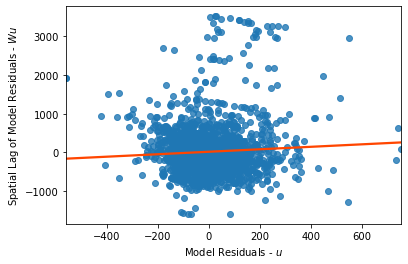

In [100]:
train_df3['residual'] = residuals3.values
train_df3['w_cities'] = w_cities

lag_residual = weights.spatial_lag.lag_spatial(w_cities, train_df3['residual'])
ax = sns.regplot(train_df3['residual'], lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Model Residuals - $W u$');

In [101]:
train_df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1863 entries, 976 to 860
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   detid            1863 non-null   object  
 1   flow             1863 non-null   float64 
 2   City             1863 non-null   object  
 3   geometry         1863 non-null   geometry
 4   NeighboursTotal  1863 non-null   float64 
 5   station          1863 non-null   int64   
 6   cycleway         1863 non-null   int64   
 7   footway          1863 non-null   int64   
 8   pedestrian       1863 non-null   int64   
 9   footwayplatform  1863 non-null   float64 
 10  Lag_Flow         1863 non-null   float64 
 11  station_log      1863 non-null   float64 
 12  cycleway_log     1863 non-null   float64 
 13  footway_log      1863 non-null   float64 
 14  pedestrian_log   1863 non-null   float64 
 15  flow_log         1863 non-null   float64 
 16  footway_2        1863 non-null   

In [102]:
# with detectors now go into LISA
mi = pys.esda.Moran(train_df3['residual'], w_cities)
print ("Moran's I is:",mi.I,)
print ('Signifcance is', mi.p_sim,)


#f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
#ax2.set_title(' '+"Moran's I:" + ' '+str(mi.I))
#moran_scatterplot(mi, ax=ax1);
#lisa = pys.esda.Moran_Local(train_df2['residual'], w_cities)
# Break observations into significant or not
#train_df2['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
#train_df2['quadrant'] = lisa.q
#Det.loc[RotterdamDet.significant == True].head()
#Det.geometry = gpd.points_from_xy(Det['X'], Det['Y'])

Moran's I is: 0.01601975858214975
Signifcance is 0.009
